C:\Users\ethan\AppData\Local\Temp\ipykernel_26764\171956025.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


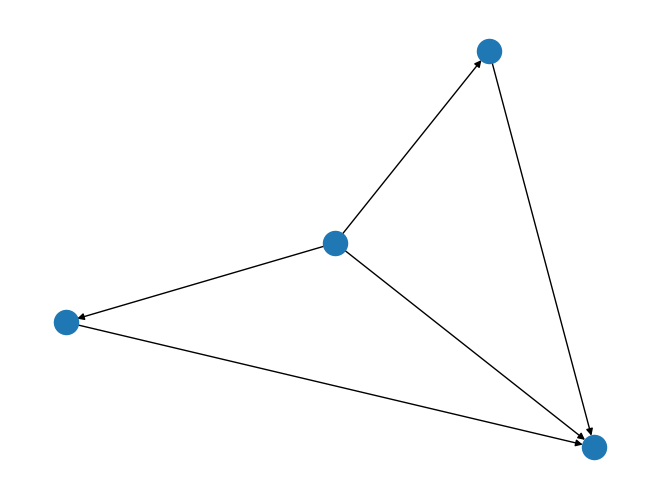

In [2]:
import networkx as nx
import random as rand
import pandas as pd
import numpy as np
import StateMachine as sm


dag = nx.DiGraph([(1,2), (1,3),(1,4),(2,4),(3,4)])

nx.draw(dag)

In [3]:
def pretty_print(G: nx.digraph, labels=True, layout=nx.planar_layout):
    pos = layout(G)
    nx.draw(G, pos, with_labels=labels)
    e_labels = nx.get_edge_attributes(G, "beta")
    for e in e_labels:
        e_labels[e] = format(e_labels[e], ".2f")
    nx.draw_networkx_edge_labels(G, pos, edge_labels = e_labels)

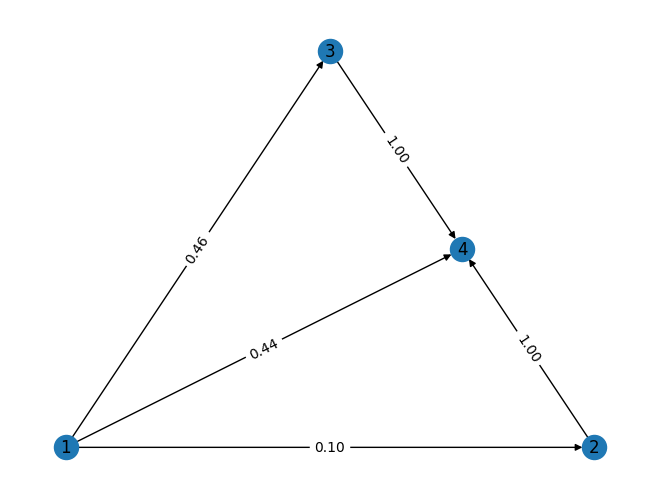

In [4]:
def addRandomBetaTerms(G: nx.digraph, self_factor=1/10):
    #for each node, with out-degree k, generate k random weights
    betas = dict()
    
    for n in G.nodes:
        neighbors = list(nx.neighbors(G,n))
        k = len(neighbors)
        beta = [rand.random() for x in range(k)] #generates a set of k random numbers
        
        #reduce the self loop
        if n in neighbors:
            beta[neighbors.index(n)]*=self_factor
    
        beta = [x/sum(beta) for x in beta] #normalize the vector to constrain the sum (not totally uniform, but good enough)
        for i, nei in enumerate(neighbors):
            betas[n, nei] = {"beta":beta[i]}
    
    nx.set_edge_attributes(G, betas)
   
addRandomBetaTerms(dag) 

pretty_print(dag)

In [5]:
def extract_beta(G: nx.digraph):
    beta = dict()
    e_weights = nx.get_edge_attributes(G, "beta")
    for n in G.nodes:
        k = list(nx.neighbors(G, n))
        w = [e_weights[n,x] for x in k]
        beta[n] = {"neighbors": k, "betas": w}
    return beta
        
print(extract_beta(dag))
    

{1: {'neighbors': [2, 3, 4], 'betas': [0.09739514898538934, 0.4630295465443179, 0.43957530447029275]}, 2: {'neighbors': [4], 'betas': [1.0]}, 3: {'neighbors': [4], 'betas': [1.0]}, 4: {'neighbors': [], 'betas': []}}


In [6]:
def generate_random_data(G: nx.digraph, n: int):
    
    
    #find start and end of the graph
    g = G.copy()
    for x in g.nodes:
        if (x,x) in g.edges:
            g.remove_edge(x,x)
    topo = list(nx.topological_sort(g))
    start = topo[0]
    end = topo[len(topo)-1]
    print(f'Detected path {start} -> {end}')
    
    # create the data structure
    data = pd.Series(data=[pd.Series() for i in range(n)])
    
    #make a random path
    beta = extract_beta(G)
    for i in range(len(data)):
        n = start
        arr = [n]
        while not n == end:
            n = rand.choices(beta[n]["neighbors"], weights=beta[n]['betas'])[0]
            arr.append(n)
        data[i]=pd.Series(arr)
    return data
    
data = generate_random_data(dag, 10)
for d in data:
    print(d)

Detected path 1 -> 4
0    1
1    3
2    4
dtype: int64
0    1
1    3
2    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    3
2    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    4
dtype: int64
0    1
1    4
dtype: int64


### Putting it all together

Detected path [] -> ['A', 'B', 'C', 'D']
6
7
5
6


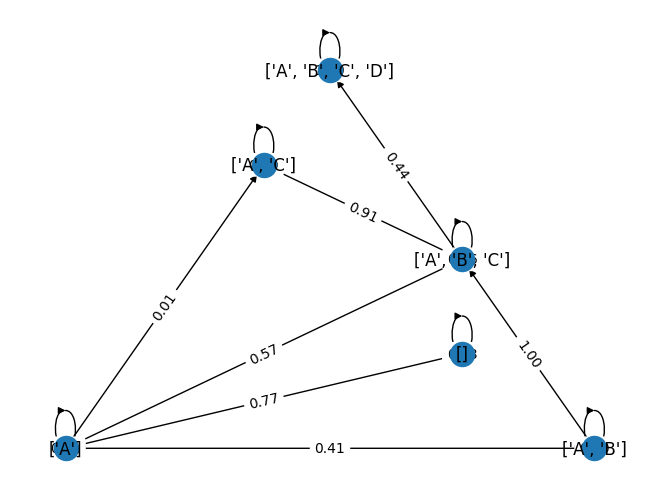

In [7]:
dag=nx.DiGraph([("A", "B"),("A", "C"), ("B", "D"), ("C", "D")])
# nx.draw(dag)
G = sm.makeStateMachine(dag)
# nx.draw(G, with_labels=True)
addRandomBetaTerms(G)
pretty_print(G)

data = generate_random_data(G, 4)
for d in data:
    
    print(len(d))


# Frequentist Fitting!!

Idea is to use frequentist estimators for all params. By definition, these estimates will comply with the constraints of being a markov chain. 

Trace through the data and count the amount of times a path is chosen against the number of times a path could have been chosen.

In [8]:
def residuals(betaActual, betaExpected, returnDict=True):
    residDict = dict()
    
    for a in betaActual.keys():
        residDict[a] = {'neighbors': betaActual[a]['neighbors'], 'betas': []}
        
        for b in betaActual[a]['neighbors']:
            vA = betaActual[a]['betas'][betaActual[a]['neighbors'].index(b)]
            vE = betaExpected[a]['betas'][betaExpected[a]['neighbors'].index(b)]
            residDict[a]['betas'].append(vA - vE)
        
    if returnDict:
        return residDict
    
    residArr = []
    for x in residDict.keys():
        residArr.extend(residDict[x]['betas'])
    
    return residArr

def rmse(betaActual, betaExpected):
    resid =residuals(betaActual, betaExpected, returnDict=False)
    resid = [x**2 for x in resid]
    s = sum(resid) / len(resid)
    r = np.sqrt(s)
    return r
        

dag=nx.DiGraph([("A", "B"),("A", "C"), ("B", "D"), ("C", "D")])
addRandomBetaTerms(dag)
r1 = extract_beta(dag)
addRandomBetaTerms(dag)
r2 = extract_beta(dag)
print(f"RMSE: {rmse(r1, r2)}")

RMSE: 0.37940929436519805


In [9]:
def parse_array(s):
    if s == '[]':
        return []
    r = s[2:-2]
    r = r.split("\', \'")
    return r
    
def parse_data(data):
    parsed = pd.Series(data=[pd.Series() for i in range(len(data))])
    for i in range(len(data)):
        arr = []
        for j in range(len(data[i])):
            arr.append(parse_array(data[i][j]))
        parsed[i] = pd.Series(data=arr)
    
    return parsed
    
    
    
a = parse_array("['A', 'B']")
print(f'{len(a)}: {a}')

2: ['A', 'B']


In [10]:
def make_empty_beta(G):
    beta = dict()
    for n in G.nodes:
        neighbors = list(nx.neighbors(G,n))
        k = len(neighbors)
        betas = [0]*k
        beta[n]={'neighbors': neighbors, 'betas': betas}
    return beta

def fit_frequentist(G, data):
    # create beta structure for G
    beta = make_empty_beta(G)
    
    # parse out the data
    data = parse_data(data)
    
    #count up the amount of transitions
    for d in data:
        # each d is a Series of states
        #for each step, add 1 to each 
        for i in range(len(d)-1):
            curState = sm.stateToString(d[i])
            nextState = sm.stateToString(d[i+1])
            
            beta[curState]['betas'][beta[curState]['neighbors'].index(nextState)] += 1
    
    # find frequentist estimators
    beta_attr = dict()
    # NOTE: im using an altered Agresti-Coull estimator, made for any number of categories
    # it makes the assumption that with no data, there is an equal chance
    # Not an exact p = x/n estimator, but in the limit is equivalent
    # not sure if the statistical benefit extends to more categories, but heres hoping
    for n in beta.keys():
        counts = beta[n]['betas']
        s = sum(counts) + 2*len(counts)
        betaEst = [(c+2)/s for c in counts]
    
        #apply betaEstimators to the attr
        for i, ni in enumerate(beta[n]['neighbors']):
            beta_attr[n,ni] = {'beta': betaEst[i]}
    nx.set_edge_attributes(G,beta_attr)
    
    # print(beta)
        

{('[]', "['A']"): ['A'], ('[]', '[]'): [], ("['A']", "['A', 'B', 'C']"): ['B', 'C'], ("['A']", "['A']"): [], ("['A', 'B']", "['A', 'B', 'C']"): ['C'], ("['A', 'B']", "['A', 'B']"): [], ("['A', 'C']", "['A', 'B', 'C', 'E']"): ['B', 'E'], ("['A', 'C']", "['A', 'C']"): [], ("['A', 'B', 'C']", "['A', 'B', 'C', 'D', 'E']"): ['D', 'E'], ("['A', 'B', 'C']", "['A', 'B', 'C']"): [], ("['A', 'B', 'C', 'D']", "['A', 'B', 'C', 'D', 'E']"): ['E'], ("['A', 'B', 'C', 'D']", "['A', 'B', 'C', 'D']"): [], ("['A', 'B', 'C', 'E']", "['A', 'B', 'C', 'D', 'E']"): ['D'], ("['A', 'B', 'C', 'E']", "['A', 'B', 'C', 'E']"): [], ("['A', 'B', 'C', 'D', 'E']", "['A', 'B', 'C', 'D', 'E', 'F']"): ['F'], ("['A', 'B', 'C', 'D', 'E']", "['A', 'B', 'C', 'D', 'E']"): [], ("['A', 'B', 'C', 'D', 'E', 'F']", "['A', 'B', 'C', 'D', 'E', 'F']"): [], ("['A', 'C', 'E']", "['A', 'B', 'C', 'E']"): ['B'], ("['A', 'C', 'E']", "['A', 'C', 'E']"): []}
Detected path [] -> ['A', 'B', 'C', 'D', 'E', 'F']
RMSE: 0.1398


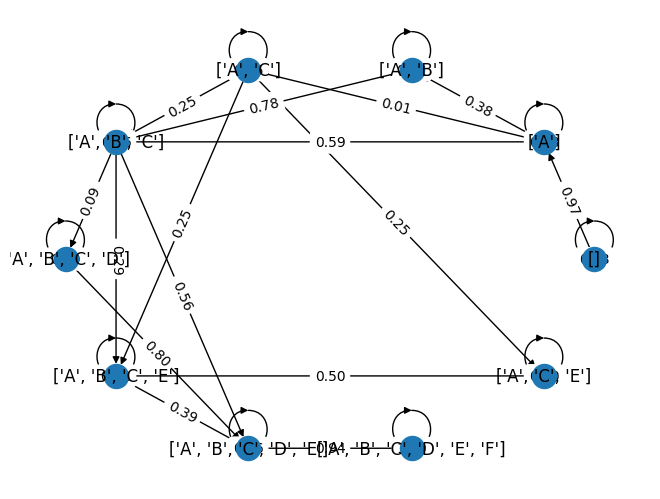

In [12]:
# dag=nx.DiGraph([("A", "B"),("A", "C"), ("B", "D"), ("C", "D")])
dag=nx.DiGraph([("A","B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E"), ("D", "F"), ("E", "F")])
G = sm.makeStateMachine(dag)
print(nx.get_edge_attributes(G, "new_classes"))
addRandomBetaTerms(G)
betaTrue = extract_beta(G).copy()
# print(betaTrue)
# pretty_print(G)
data = generate_random_data(G, 250)

fit_frequentist(G,data);
betaHat = extract_beta(G)
# print(betaHat)

print('RMSE: {:.4f}'.format(rmse(betaHat, betaTrue)))
pretty_print(G, layout=nx.circular_layout)


Detected path [] -> ['CSCI128', 'CSCI261', 'CSCI262', 'CSCI274', 'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406', 'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332', 'MATH334']
RMSE: 0.0519


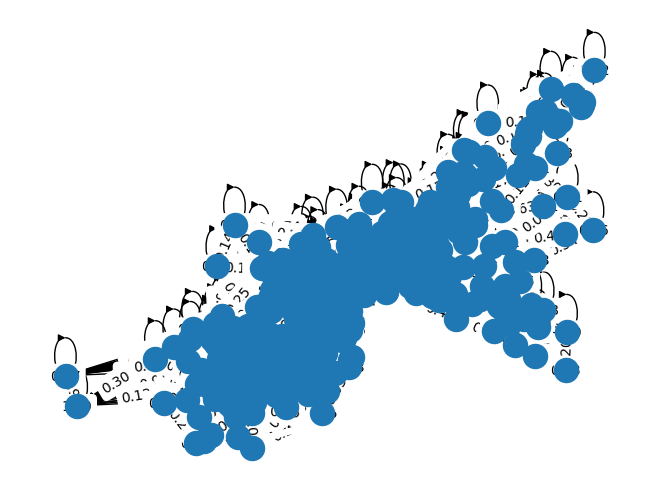

In [21]:
import PreReqs
dag= PreReqs.getPrereqGraph()
G = sm.makeStateMachine(dag)
addRandomBetaTerms(G)
betaTrue = extract_beta(G).copy()
# print(betaTrue)
# pretty_print(G)
data = generate_random_data(G, 1000)

fit_frequentist(G,data);
betaHat = extract_beta(G)
# print(betaHat)

print('RMSE: {:.4f}'.format(rmse(betaHat, betaTrue)))
pretty_print(G, layout=nx.spring_layout, labels=False)

# Testing it as a module

Detected path [] -> ['CSCI128', 'CSCI261', 'CSCI262', 'CSCI274', 'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406', 'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332', 'MATH334']
{'[]': {'neighbors': ["['CSCI341']", "['MATH111']", "['CSCI128']", "['CSCI341', 'MATH111']", "['CSCI128', 'CSCI341']", "['CSCI128', 'MATH111']", "['CSCI128', 'CSCI341', 'MATH111']", '[]'], 'betas': [0.177734375, 0.1728515625, 0.1279296875, 0.1005859375, 0.087890625, 0.0703125, 0.2529296875, 0.009765625]}, "['CSCI341']": {'neighbors': ["['CSCI341', 'MATH111']", "['CSCI128', 'CSCI341']", "['CSCI128', 'CSCI341', 'MATH111']", "['CSCI341']"], 'betas': [0.3520408163265306, 0.37244897959183676, 0.22448979591836735, 0.05102040816326531]}, "['MATH111']": {'neighbors': ["['MATH111', 'MATH112']", "['CSCI341', 'MATH111']", "['CSCI128', 'MATH111']", "['CSCI341', 'MATH111', 'MATH112']", "['CSCI128', 'MATH111', 'MATH112']", "['CSCI128', 'CSCI341', 'MATH111']", "['CSCI128', 'CSCI341', 'MATH111', 'MATH112']",

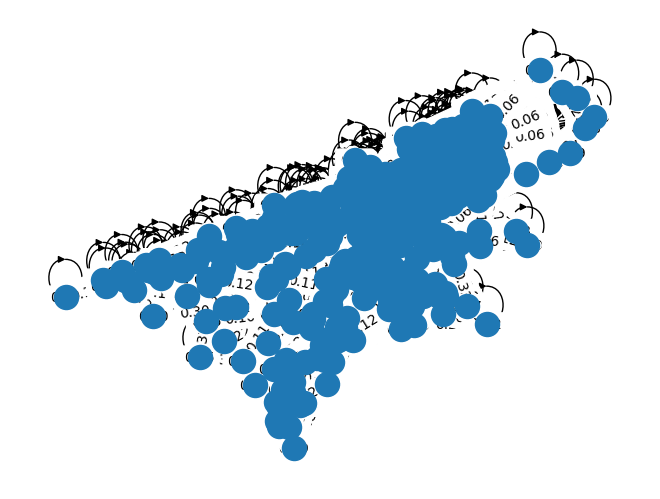

In [7]:
import networkx as nx
import PreReqs
import StateMachine as sm
import FrequentistFitting as ffit


#get the model
dag = PreReqs.getPrereqGraph()
G = sm.makeStateMachine(dag)

#this is to generate random data with assumed Beta values
ffit.addRandomBetaTerms(G)
data = ffit.generate_random_data(G, 1000)

#fit the model to the data
ffit.fit_frequentist(G, data)

#can extract the betas, or print it
print(ffit.extract_beta(G))
ffit.pretty_print(G, layout=nx.spring_layout, labels=False) #if the state machine isnt planar you must include the layout term to provide a different one